In [10]:
%matplotlib inline
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="1"; 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix,explained_variance_score
import time
from datetime import timedelta
import math
import pickle
import pandas
from datapipe import bin_ndarray
from skimage import io

In [11]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Input, Dense, Flatten, GlobalAveragePooling2D, Conv1D,Conv2D, MaxPooling2D,MaxPooling1D, Dropout, UpSampling2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [12]:
whisk = io.imread('./data/whiskContrast.tif')
np.random.seed(42)
(length, lenx, leny) = whisk.shape
print(whisk.shape)
print(lenx,leny)

(21406, 126, 136)
126 136


In [13]:
#though I was going to do multiple in this file but maybe if I have multiple 
data = whisk

In [14]:
num_data = len(data)
train_split = 0.7
validation_split = 0.1
num_train = int(train_split*num_data)
num_val = int((num_data - num_train)*validation_split)
num_test = num_data - num_train - num_val
x_train = data[0:num_train].reshape(num_train, (lenx*leny))
x_test = data[(num_train):].reshape(num_test+num_val, (lenx*leny))

In [15]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [16]:
x_test_scaled = x_scaler.transform(x_test)

In [44]:
input_img = Input(shape=(lenx, leny, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (2, 2), activation='relu', padding='same')(input_img)
x = MaxPooling2D((3, 2), padding='same')(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((3, 2), padding='same')(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Dense(2000, activation='relu')(encoded)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((3, 2))(x)
x = Conv2D(64, (2, 2), activation='relu',padding='same')(x)
x = UpSampling2D((3, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [45]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 126, 136, 1)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 126, 136, 64)      320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 42, 68, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 42, 68, 32)        8224      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 34, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 34, 16)        2064      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 17, 16)         0         
__________

In [46]:
print(lenx,leny)
x_train = x_train_scaled.reshape((num_train, lenx,leny,1))
x_test = x_test_scaled.reshape((num_test+num_val, lenx, leny, 1))
print(x_test.shape)

126 136
(6422, 126, 136, 1)


In [47]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [48]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [49]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [50]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [51]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]
print(x_train.shape)

(14984, 126, 136, 1)


In [52]:
%%time
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks)

Train on 14984 samples, validate on 6422 samples
Epoch 1/30
14984/14984 [==============================] - 67s 4ms/step - loss: 0.5657 - val_loss: 0.4653

Epoch 00001: val_loss improved from inf to 0.46527, saving model to 23_checkpoint.keras
Epoch 2/30
14984/14984 [==============================] - 65s 4ms/step - loss: 0.4734 - val_loss: 0.4629

Epoch 00002: val_loss improved from 0.46527 to 0.46286, saving model to 23_checkpoint.keras
Epoch 3/30
14984/14984 [==============================] - 65s 4ms/step - loss: 0.4624 - val_loss: 0.4503

Epoch 00003: val_loss improved from 0.46286 to 0.45029, saving model to 23_checkpoint.keras
Epoch 4/30
14984/14984 [==============================] - 66s 4ms/step - loss: 0.4553 - val_loss: 0.4485

Epoch 00004: val_loss improved from 0.45029 to 0.44848, saving model to 23_checkpoint.keras
Epoch 5/30
14984/14984 [==============================] - 66s 4ms/step - loss: 0.4506 - val_loss: 0.4442

Epoch 00005: val_loss improved from 0.44848 to 0.44424, s

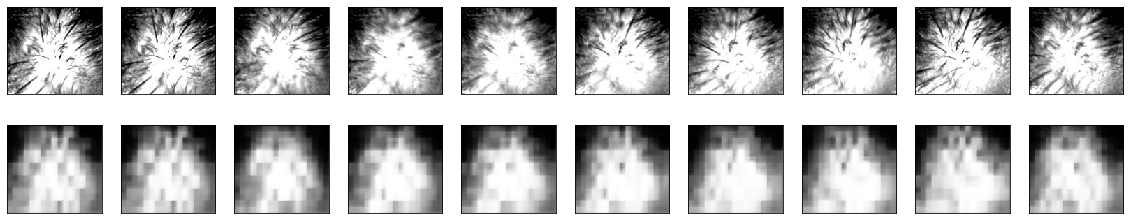

In [43]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i+30].reshape(lenx, leny))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i+30].reshape(lenx, leny))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [33]:
autoencoder.save('whiskEncoder.h5')